In [1]:
import numpy as np
from datascience import *
import math as m
import qgrid as q
import pandas as pd
from scipy.stats import chi2_contingency

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

def nan_sum(arr):
    sum = 0
    for elem in arr:
        if not math.isnan(elem):
            sum += elem

***Data Cleaning***

In [2]:
original_data = Table.read_table("community_RR_csv.csv");
q.show_grid(original_data.to_df())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [3]:
original_data_caninervis = original_data.where("Syntrichia caninervis cover", are.not_equal_to("0%"))
original_data_caninervis

Coordinates,Exposure of S. caninervis,Number of S. caninervis sporophytes,Stem height,Stem height: exposed,Stem height: shaded,Number of inflorescences,No. Infl. per expressing ramet: exposed,No. Infl. per expressing ramet: shaded,"Sex (M,F,S)",Stem height sorted,No. inflor by sorted st ht,No. inflor sorted,St ht sorted by no. infl,Syntrichia caninervis cover,Syntrichia ruralis cover,Bryum algovicum cover,Bryum argenteum cover,Pterogoneurum spp. cover,Grimmia cover,Unknown sp. cover,Total bryophyte cover,Total lichen cover,Total cryptogam cover,Unnamed: 24,Unnamed: 25
T1 30,I,0,2.9,2,2.9,0,1,1,S,0.5,0,0,0.5,5%,0%,0%,0%,0%,0%,0%,5.00%,0%,5%,nan,nan
T1 30,I,nan,1.7,2.6,1.7,0,1,1,S,0.5,0,0,0.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,1.5,1.9,1.5,0,1,1,S,0.5,0,0,0.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,2,2.2,2,0,1,1,S,0.5,0,0,0.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,2.9,1.9,2.9,0,1,1,S,0.6,0,0,0.6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,3.1,2,3.1,1,2,1,F,0.6,0,0,0.6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,2.1,2.3,2.1,0,1,1,S,0.6,0,0,0.6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,2.8,1.2,2.8,0,2,2,S,0.6,0,0,0.6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,2,1.8,2,0,1,1,S,0.6,0,0,0.6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T1 30,I,nan,2,1.9,2,0,2,1,S,0.6,0,0,0.6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [4]:
small_data = original_data_caninervis.drop(2,4,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25)
small_data.show(1000)

Coordinates,Exposure of S. caninervis,Stem height,Number of inflorescences,"Sex (M,F,S)"
T1 30,I,2.9,0,S
T1 30,I,1.7,0,S
T1 30,I,1.5,0,S
T1 30,I,2,0,S
T1 30,I,2.9,0,S
T1 30,I,3.1,1,F
T1 30,I,2.1,0,S
T1 30,I,2.8,0,S
T1 30,I,2,0,S
T1 30,I,2,0,S


***Making Bowker Table 2***

In [5]:
def my_round(num):
    return round(num, 3)

In [6]:
# Gets unique value of a column in a table and return an array
def unique_values(table, column_name):
    return table.select(column_name).group(column_name).column(column_name)

In [7]:
# Calculates a number of ramets that meet a given value in S. caninervis
# that parameter is table given is filtered by sex
def number_of_ramets(table, ramet, column, condition, that=False):
    if that == True:
        return table.where('Coordinates', ramet).where(column, condition).group(0).num_rows
    return table.where('Coordinates', ramet).where(column, condition).num_rows

In [8]:
def table2_column1(table):
    female_count = 0
    male_count = 0
    for ramet in unique_values(table, 'Coordinates'):
        female_count += number_of_ramets(table, ramet, 'Sex (M,F,S)', 'F')
        male_count += number_of_ramets(table, ramet, 'Sex (M,F,S)', 'M')
    return make_array(male_count, female_count, female_count + male_count)
table2_column1(small_data)

array([  9, 128, 137])

In [9]:
def table2_column2(table):   
    male_infloresence = 0
    female_infloresence = 0
    for ramet in unique_values(table, 'Coordinates'):  
        female_infloresence += number_of_ramets(table.where('Sex (M,F,S)', 'F'), ramet, 'Number of inflorescences', are.above(0), that=True)
        male_infloresence += number_of_ramets(table.where('Sex (M,F,S)', 'M'), ramet, 'Number of inflorescences', are.above(0), that=True)
    return make_array(male_infloresence, female_infloresence, male_infloresence + female_infloresence)
table2_column2(small_data)

array([ 3, 41, 44])

In [10]:
def table2_column3(table):
    m_table = table.where('Sex (M,F,S)', 'M').where('Number of inflorescences', are.above(0))
    f_table = table.where('Sex (M,F,S)', 'F').where('Number of inflorescences', are.above(0))
    male_sum_infloresence = sum(m_table.column('Number of inflorescences'))
    female_sum_infloresence = sum(f_table.column('Number of inflorescences'))
    num_ramets = table2_column1(table)
    m_avg = my_round(male_sum_infloresence/num_ramets.item(0))
    f_avg = my_round(female_sum_infloresence/num_ramets.item(1))
    t_avg = my_round((male_sum_infloresence + female_sum_infloresence) / num_ramets.item(2))
    return make_array(m_avg, f_avg, t_avg)
table2_column3(small_data)

array([1.   , 1.195, 1.182])

In [11]:
def table2_column4(table):
    m_more_than_1 = table.where('Sex (M,F,S)', 'M').where('Number of inflorescences', are.above(1)).num_rows
    f_more_than_1 = table.where('Sex (M,F,S)', 'F').where('Number of inflorescences', are.above(1)).num_rows
    num_ramets = table2_column1(table)
    m_prop = my_round(m_more_than_1 / num_ramets.item(0))
    f_prop = my_round(f_more_than_1 / num_ramets.item(1))
    t_prop = my_round((m_more_than_1 + f_more_than_1) / num_ramets.item(2))
    return make_array(m_prop, f_prop, t_prop)
table2_column4(small_data)

array([0.   , 0.164, 0.153])

In [12]:
def table2(table):
    column1 = table2_column1(table)
    column2 = table2_column2(table)
    column3 = table2_column3(table)
    column4 = table2_column4(table)
    rtn_table = Table().with_column('Sex', ['Male', 'Female', 'Total'])
    rtn_table = rtn_table.with_columns('No. ramets expressing sex in life span', column1,
                               'No. ramets currently expressing sex', column2,
                               'No. inflorescences per ramet', column3,
                               'Proportion of ramets with >1 inflorescence', column4)
    return rtn_table
table2(small_data)

Sex,No. ramets expressing sex in life span,No. ramets currently expressing sex,No. inflorescences per ramet,Proportion of ramets with >1 inflorescence
Male,9,3,1,0
Female,128,41,1.195,0.164
Total,137,44,1.182,0.153


***Making Bowker Table 3***

In [13]:
small_data

Coordinates,Exposure of S. caninervis,Stem height,Number of inflorescences,"Sex (M,F,S)"
T1 30,I,2.9,0,S
T1 30,I,1.7,0,S
T1 30,I,1.5,0,S
T1 30,I,2,0,S
T1 30,I,2.9,0,S
T1 30,I,3.1,1,F
T1 30,I,2.1,0,S
T1 30,I,2.8,0,S
T1 30,I,2,0,S
T1 30,I,2,0,S


In [14]:
def mean_ramet_height(table):
    heights = table.column('Stem height')
    return np.mean(heights)
mean_ramet_height(small_data)

1.9042696629213482

In [15]:
def classify_height(benchmark):
    def classify_help(number):
        if (number > benchmark):
            return 'tall'
        else:
            return 'short'
    return classify_help

In [16]:
def classify_by_factor(table, col, func):
    benchmark = func(table)
    labeler = classify_height(benchmark)
    data = table.apply(labeler, col)
    col_label = col + ' classified by ' + func.__name__
    return table.with_column(col_label, data)
pre_contingency = classify_by_factor(small_data, 'Stem height', mean_ramet_height).to_df()
pre_contingency.head()

,Coordinates,Exposure of S. caninervis,Stem height,Number of inflorescences,"Sex (M,F,S)",Stem height classified by mean_ramet_height
0,T1 30,I,2.9,0.0,S,tall
1,T1 30,I,1.7,0.0,S,short
2,T1 30,I,1.5,0.0,S,short
3,T1 30,I,2.0,0.0,S,tall
4,T1 30,I,2.9,0.0,S,tall


In [17]:
contingency = pd.crosstab([pre_contingency['Exposure of S. caninervis'] , pre_contingency['Stem height classified by mean_ramet_height']], pre_contingency['Sex (M,F,S)'], margins = False)
contingency['Expressing sex'] = contingency['F'] + contingency['M']
contingency['Not expressing sex'] = contingency['S']
contingency = contingency.drop(columns = ['M','F','S'])
contingency

Sex (M,F,S)                                                            Expressing sex  \
Exposure of S. caninervis Stem height classified by mean_ramet_height                   
I                         short                                                    14   
                          tall                                                     50   
O                         short                                                     2   
                          tall                                                     28   
U                         short                                                     6   
                          tall                                                     32   
nan                       short                                                     0   
                          tall                                                      5   

Sex (M,F,S)                                                            Not expressing sex  
Exposure of S. caninervis Stem height classified by mean_ramet_height                      
I                         short                                                       193  
                          tall                                                        124  
O                         short                                                       205  
                          tall                                                         95  
U                         short                                                        52  
                          tall                                                         70  
nan                       short                                                         4  
                          tall                                                         10

In [18]:
chi2, p_val, dof, expected = chi2_contingency(contingency)
(chi2, p_val, dof, expected)

(99.40153104419883,
 1.4338726900120577e-18,
 7,
 array([[ 31.86404494, 175.13595506],
        [ 26.78426966, 147.21573034],
        [ 31.86404494, 175.13595506],
        [ 18.93370787, 104.06629213],
        [  8.92808989,  49.07191011],
        [ 15.7011236 ,  86.2988764 ],
        [  0.61573034,   3.38426966],
        [  2.30898876,  12.69101124]]))

In [19]:
def crosstab(table, label, func):
    pre_contingency = classify_by_factor(table, label, func).to_df()
    contingency = pd.crosstab([pre_contingency['Exposure of S. caninervis'] , pre_contingency[label + ' classified by ' + func.__name__]], pre_contingency['Sex (M,F,S)'], margins = False)
    contingency['Expressing sex'] = contingency['F'] + contingency['M']
    contingency['Not expressing sex'] = contingency['S']
    contingency = contingency.drop(columns = ['M','F','S'])
    return chi2_contingency(contingency)
crosstab(small_data, 'Stem height', mean_ramet_height)

(99.40153104419883,
 1.4338726900120577e-18,
 7,
 array([[ 31.86404494, 175.13595506],
        [ 26.78426966, 147.21573034],
        [ 31.86404494, 175.13595506],
        [ 18.93370787, 104.06629213],
        [  8.92808989,  49.07191011],
        [ 15.7011236 ,  86.2988764 ],
        [  0.61573034,   3.38426966],
        [  2.30898876,  12.69101124]]))

In [20]:
labels_for_x2 = ['Stem height']

In [21]:
funcs_for_x2 = [mean_ramet_height]

In [22]:
def table3(table):
    labels_for_x2 = ['Stem height']
    funcs_for_x2 = [mean_ramet_height]
    labels_func_map = dict(zip(labels_for_x2,funcs_for_x2))
    return crosstab(table, labels_for_x2[0], funcs_for_x2[0])

***Making General Functions***

In [23]:
headers = list(small_data.labels)
headers

['Coordinates',
 'Exposure of S. caninervis',
 'Stem height',
 'Number of inflorescences',
 'Sex (M,F,S)']

In [24]:
def bowker(table):
    assert table.labels == small_data.labels, ("Column headers must be as follows: " + headers)
    return table3(table)

In [25]:
bowker(small_data)

(99.40153104419883,
 1.4338726900120577e-18,
 7,
 array([[ 31.86404494, 175.13595506],
        [ 26.78426966, 147.21573034],
        [ 31.86404494, 175.13595506],
        [ 18.93370787, 104.06629213],
        [  8.92808989,  49.07191011],
        [ 15.7011236 ,  86.2988764 ],
        [  0.61573034,   3.38426966],
        [  2.30898876,  12.69101124]]))

In [26]:
small_data

Coordinates,Exposure of S. caninervis,Stem height,Number of inflorescences,"Sex (M,F,S)"
T1 30,I,2.9,0,S
T1 30,I,1.7,0,S
T1 30,I,1.5,0,S
T1 30,I,2,0,S
T1 30,I,2.9,0,S
T1 30,I,3.1,1,F
T1 30,I,2.1,0,S
T1 30,I,2.8,0,S
T1 30,I,2,0,S
T1 30,I,2,0,S


(0.3008562793583733, -2.740863092043355e-16)

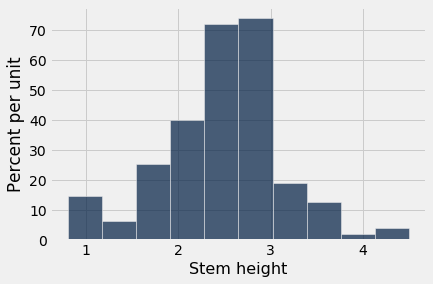

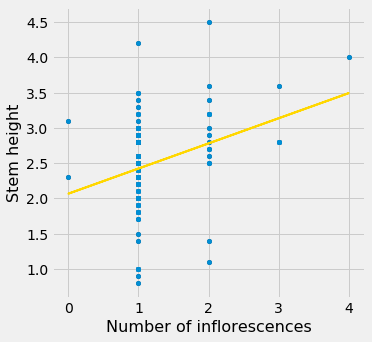

In [27]:
#distribution of stem height for females
small_data.where('Sex (M,F,S)', 'F').hist('Stem height')
small_data.where('Sex (M,F,S)', 'F').scatter('Number of inflorescences','Stem height')
scatter_fit(small_data.where('Sex (M,F,S)', 'F'),'Number of inflorescences','Stem height')
correlation(small_data.where('Sex (M,F,S)', 'F'),'Number of inflorescences','Stem height'), np.mean(residual(small_data.where('Sex (M,F,S)', 'F'),'Number of inflorescences','Stem height'))

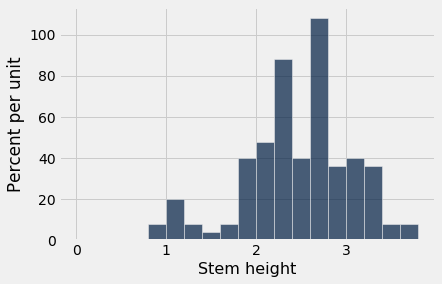

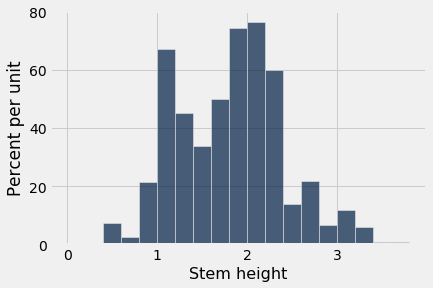

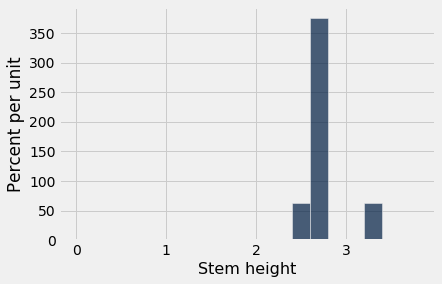

In [28]:
small_data.where('Sex (M,F,S)', 'F').hist('Stem height', bins=np.arange(0,4,0.2))
small_data.where('Sex (M,F,S)', 'S').hist('Stem height', bins=np.arange(0,4,0.2))
small_data.where('Sex (M,F,S)', 'M').hist('Stem height', bins=np.arange(0,4,0.2))

***Looking at Our Data***

In [43]:
height_data = small_data.select(0,2).group("Coordinates", np.average)
height_data

Coordinates,Stem height average
T1 105,1.96
T1 135,1.84
T1 150,1.1
T1 165,1.03
T1 180,1.47
T1 195,1.16
T1 210,1.54
T1 240,2.48
T1 30,2.3
T1 45,1.38


In [30]:
our_data_unclean = Table.read_table("sexratiodatadraft.csv");
our_data_unclean

Genomics_ID,Sample_ID,loc,lat,lon,Coordinates: Exact or Approximate?,Species,Expressed Sex,Leaf Dissection?,Photos,Grid?,Collector,Collection Year,Extraction #,PCR #,DIGEST #,Inferred Genetic Sex
GJB341,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,17,39,24,F
GJB342,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,17,39,24,F
GJB343,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,17,39,24,F
GJB344,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,17,39,24,F
GJB345,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,17,39,24,F
GJB346,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,17,39,24,F
GJB347,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,18,42,24,F
GJB348,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,18,42,24,F
GJB349,BOWKER-T1-30,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,18,42,24,F
GJB349*,BOWKER-T1-30.1,nan,nan,nan,nan,S. caninervis,U,nan,nan,nan,M. Bowker,1997,nan,39,24,F


In [31]:
our_data = our_data_unclean.select(0,1,13,16).where('Inferred Genetic Sex', are.not_equal_to('nan'))
our_data

Genomics_ID,Sample_ID,Extraction #,Inferred Genetic Sex
GJB341,BOWKER-T1-30,17,F
GJB342,BOWKER-T1-30,17,F
GJB343,BOWKER-T1-30,17,F
GJB344,BOWKER-T1-30,17,F
GJB345,BOWKER-T1-30,17,F
GJB346,BOWKER-T1-30,17,F
GJB347,BOWKER-T1-30,18,F
GJB348,BOWKER-T1-30,18,F
GJB349,BOWKER-T1-30,18,F
GJB349*,BOWKER-T1-30.1,nan,F


In [32]:
def transect(str):
    for i in range(len(str)):
        if str[i] == "T":
            end = i + 2
            return str[i:i+2]

In [33]:
transect("BOWKER-T1-30")

'T1'

In [34]:
def loc(str):
    for i in range(len(str)):
        if str[i] == "T":
            start = i + 3
            return str[start:start+2]

In [35]:
loc("BOWKER-T1-30")

'30'

In [47]:
transect_data = our_data.apply(transect, "Sample_ID")
location_data = our_data.apply(loc, "Sample_ID")
location_and_sex = our_data.drop(1,2).with_columns("Transect", transect_data, "Location on Transect", location_data)
location_and_sex.show(200)

Genomics_ID,Inferred Genetic Sex,Transect,Location on Transect
GJB341,F,T1,30
GJB342,F,T1,30
GJB343,F,T1,30
GJB344,F,T1,30
GJB345,F,T1,30
GJB346,F,T1,30
GJB347,F,T1,30
GJB348,F,T1,30
GJB349,F,T1,30
GJB349*,F,T1,30


In [37]:
t1_data = location_and_sex.where("Transect", "T1")
t1_data

Genomics_ID,Inferred Genetic Sex,Transect,Location on Transect
GJB341,F,T1,30
GJB342,F,T1,30
GJB343,F,T1,30
GJB344,F,T1,30
GJB345,F,T1,30
GJB346,F,T1,30
GJB347,F,T1,30
GJB348,F,T1,30
GJB349,F,T1,30
GJB349*,F,T1,30


In [38]:
def group_check(table):
    count = 0
    for elem in table.column("Inferred Genetic Sex"):
        count += 1
    if count == 1:
        return table.append(Table().with_columns("Inferred Genetic Sex", make_array("M"), "count", 0))
    return table

In [39]:
def female_and_male_count(table, transect, loc):
    new_table = table.where("Location on Transect", loc)
    group_table = group_check(new_table.group("Inferred Genetic Sex"))
    rtn_table = Table().with_columns("Transect", make_array(transect, transect), 
                                   "Location on Transect", make_array(loc, loc),
                                   "Sex", make_array("F", "M"))
    return rtn_table.with_column("Sex Count", group_table.column("count"))

In [57]:
female_and_male_count(t1_data, "T1", "45")

Transect,Location on Transect,Sex,Sex Count
T1,45,F,9
T1,45,M,0


In [46]:
height_data.sort("Stem height average").show(100)

Coordinates,Stem height average
T4 195,0.95
T4 435,0.95
T1 165,1.03
T1 150,1.1
T1 195,1.16
T4 225,1.17
T4 600,1.2
T2 255,1.21
T2 390,1.23
T2 45,1.29


In [53]:
original_data = Table.read_table("community_RR_csv.csv");
original_data.select(0,6,9).where("Sex (M,F,S)", "M")

Coordinates,Number of inflorescences,"Sex (M,F,S)"
T2 30,1,M
T3 645,1,M
T3 645,1,M
T3 645,1,M
T4 585,1,M
T4 585,1,M
T4 585,1,M
T4 585,1,M
T4 585,1,M


In [56]:
original_data.select(0,1,9).where("Sex (M,F,S)", "M")

Coordinates,Exposure of S. caninervis,"Sex (M,F,S)"
T2 30,U,M
T3 645,I,M
T3 645,I,M
T3 645,I,M
T4 585,I,M
T4 585,I,M
T4 585,I,M
T4 585,I,M
T4 585,I,M


***For Botany Talk***